# Spot-to-spot Alignment of MBSP Data Incorporating Histological Images

This tutorial is conceptually similar to Tutorial 1 (DLPFC alignment), but here we focus on the **mouse brain sagittal–posterior (MBSP) dataset**.  
We demonstrate GALA’s ability to integrate **spatial coordinates, gene expression profiles, and histological images** to perform accurate spot-to-spot alignment across sagittal and posterior slices.  
This example highlights the robustness of GALA across different tissue types and experimental datasets.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scanpy as sc
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.patches import Rectangle,ConnectionPatch
from matplotlib.lines import Line2D
import time
import pickle
import os



import warnings
for cat in [FutureWarning, DeprecationWarning]:
    warnings.filterwarnings("ignore", category=cat)

# data loading path
data_path = os.path.expanduser('../Data/MBSP')  # Update this path to your data directory  
results_path = os.path.expanduser('./Results/tutorials')  # Directory to save results
os.makedirs(results_path, exist_ok=True)

# Load and Preprocess Data

The original dataset was downloaded from 10x Genomics:  

- [Mouse Brain Serial Section 1, Sagittal Posterior](https://www.10xgenomics.com/datasets/mouse-brain-serial-section-1-sagittal-posterior-1-standard-1-1-0)  
- [Mouse Brain Serial Section 2, Sagittal Posterior](https://www.10xgenomics.com/datasets/mouse-brain-serial-section-2-sagittal-posterior-1-standard-1-1-0)  

In this tutorial, **Section 1** is treated as the **source** and **Section 2** as the **target**.  

Data processing follows these steps:  

1. Gene and cell filtering  
2. Normalization of expression counts  
3. Logarithmic transformation  
4. Selection of highly variable genes  
5. Selection of top $p = 3$ informative genes for alignment

In [2]:
from GALA.utils import process_Visium_data,top_p_genes
# slice 1
source = sc.read_h5ad(os.path.join(data_path, "Section1_lowres.h5ad")) 
source = process_Visium_data(source,n_top_genes=6000)

# slice 2
target = sc.read_h5ad(os.path.join(data_path, "Section2_lowres.h5ad")) 
target = process_Visium_data(target,n_top_genes=6000)

# common genes
shared_gene_names = target.var_names.intersection(source.var_names)
target = target[:,shared_gene_names]
source = source[:,shared_gene_names]

# dx \approx 1
scale = source.uns['scales']
dx = scale['tissue_lowres_scalef']*20
print(f"dx = {dx:.2f}")

# Select top genes for alignment
top_gene_names = top_p_genes(source, shared_gene_names, p =3)
print(f"Genes {top_gene_names} are selected for alignment.")

### Construct expression matrices with total counts appended
# source 
X = np.array(source[:,top_gene_names].X.todense())
gi = np.array(source.X.sum(axis=1))
si = np.concatenate([X, gi], axis=1)
spatiali = source.obsm['spatial']

# target
X = np.array(target[:,top_gene_names].X.todense())
gj = np.array(target.X.sum(axis = 1))
sj = np.concatenate([X, gj], axis=1)
spatialj = target.obsm['spatial']

dx = 1.03
Genes Index(['Pcp2', 'Mbp', 'Nrgn'], dtype='object') are selected for alignment.


Visualization of raw data. The color of each spot represents gene expression levels, with higher values shown in lighter colours.

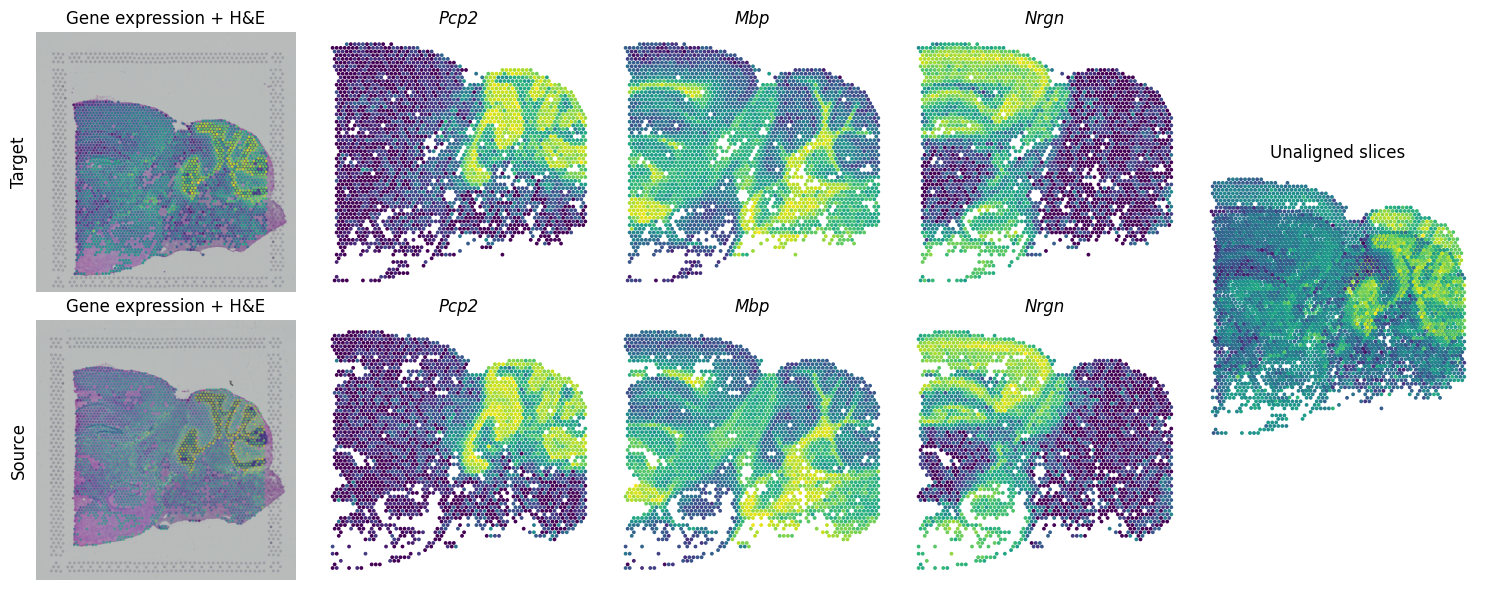

In [3]:
fig = plt.figure(figsize=(15, 6))
# Point sizes for scatter plots
ps1 = 1  # for overall gene expression + H&E overlay
ps2 = 3  # for individual gene expression plots
gs = gridspec.GridSpec(2, 5)
ax1 = fig.add_subplot(gs[0, 0])  
ax2 = fig.add_subplot(gs[1, 0])  
### Target
img = target.uns['lowres_image']
ax1.imshow(img)
ax1.axis('off')
ax1.scatter(spatialj[:,0],spatialj[:,1],s=ps1,alpha = 0.8,c = gj,cmap = 'viridis')
ax1.set_title('Gene expression + H&E',fontsize = 12)

# plot gene expression for target
for i, gene in enumerate(top_gene_names, start=1):
    expression = target[:, gene].X.toarray().flatten()
    ax = fig.add_subplot(gs[0,i])
    ax.scatter(spatialj[:, 0],spatialj[:, 1],c=expression,s=ps2,cmap='viridis')
    ax.set_title(f'{gene}',size = 12,fontstyle='italic')
    ax.axis('off')
    ax.invert_yaxis()  

### Source
img = source.uns['lowres_image']
ax2.imshow(img)
ax2.scatter(spatiali[:,0],spatiali[:,1],s=ps1,alpha = 0.5,c = gi,cmap = 'viridis')
ax2.axis('off')
ax2.set_title('Gene expression + H&E',fontsize = 12)

# plot gene expression for source
for i, gene in enumerate(top_gene_names, start=1):
    expression = source[:, gene].X.toarray().flatten()
    ax = fig.add_subplot(gs[1,i])
    ax.scatter(spatiali[:, 0],spatiali[:, 1],c=expression,s=ps2,cmap='viridis')
    ax.set_title(f'{gene}',size = 12, fontstyle='italic')
    ax.axis('off')
    ax.set_aspect('equal')
    ax.invert_yaxis()  

ax1.text(-0.1, 0.5, 'Target', fontsize=12, rotation='vertical',transform=ax1.transAxes, verticalalignment='center')
ax2.text(-0.1, 0.5, 'Source', fontsize=12, rotation='vertical',transform=ax2.transAxes, verticalalignment='center')

### Stacked slices
ax = fig.add_subplot(gs[:,4])
ax.scatter(spatiali[:,0], spatiali[:,1], c= gi,cmap='viridis', s= ps2, alpha=1)
ax.scatter(spatialj[:,0], spatialj[:,1], c= gj,cmap='viridis', s= ps2, alpha=1)
ax.set_title('Unaligned slices')
ax.axis('off')
ax.set_aspect('equal')
ax.invert_yaxis()  


plt.tight_layout()
plt.show()



# Rasterization
Convert spot-level expression and images into regular 2D grids

In [4]:
from GALA.utils import rasterize_channel, rasterize_image

# Fusion weight of gene expression and histology (0 = only image, 1 = only expression. Default as 0.5)
alp = 0.5
XI,YI,I_expr = rasterize_channel(spatiali[:,0], spatiali[:,1], si,dx = dx)
XJ,YJ,J_expr = rasterize_channel(spatialj[:,0], spatialj[:,1], sj,dx = dx)

### Image
if alp ==1.0:
    I = I_expr
    J = J_expr
else :
    # Source
    imgi = source.uns['lowres_image']
    _,_,I_img = rasterize_image(spatiali[:,0], spatiali[:,1], imgi,dx = dx)
    I_img = I_img[None,...]
    I = np.concatenate([alp*I_expr,(1-alp)*I_img],axis = 0)
    
    # Target
    imgj = target.uns['lowres_image']
    _,_,J_img = rasterize_image(spatialj[:,0], spatialj[:,1], imgj, dx = dx)
    J_img = J_img[None,...]
    J = np.concatenate([alp*J_expr,(1-alp)*J_img],axis = 0)
# Prepare coordinates for rasterized arrays
xI = [YI,XI]
xJ = [YJ,XJ]

0 of 2805
2804 of 2805
0 of 2874
2873 of 2874
0 of 2805
2804 of 2805
0 of 2874
2873 of 2874


Visualize rasterized expression and histology images

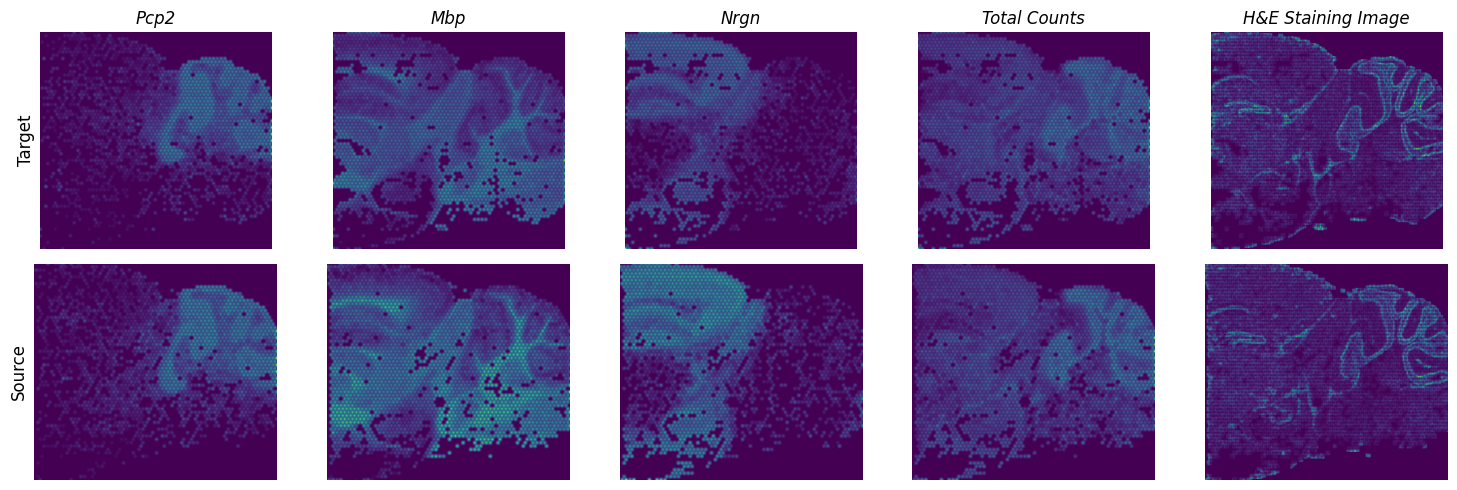

In [5]:
# Column names for the 5 channels: top genes, total counts, H&E image
colnames = ['Pcp2', 'Mbp', 'Nrgn', 'Total Counts', 'H&E Staining Image']
fig, axs = plt.subplots(2, 5,figsize=(15, 5))
axs[0, 0].text(-0.1, 0.5, 'Target', fontsize=12, rotation='vertical',
               transform=axs[0, 0].transAxes, verticalalignment='center')
axs[1, 0].text(-0.1, 0.5, 'Source', fontsize=12, rotation='vertical',
               transform=axs[1, 0].transAxes, verticalalignment='center')
# Display each channel in a column
for i in range(5):
    axs[0, i].imshow(I[i])
    axs[0, i].set_title(colnames[i], fontsize=12,fontstyle='italic')
    axs[1, i].imshow(J[i])
    axs[0, i].axis('off')
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

# GALA


In [6]:
from GALA.gala import gala
from GALA.utils import to_cpu

# Prior setting for more efficient global search in GA. This step is optional. 
# Based on observations of the raw slices, incorporating prior knowledge can improve GA performance and robustness by constraining the search space and reducing the number of free parameters.
gene_space=[
            {'low': -45, 'high': 45},   # angle
            {'low': 1.0, 'high': 1.0},  # sy
            {'low': 1.0, 'high': 1.0},  # sx
            {},  # ty
            {}   # tx
        ]

    ### Whole framework
params = {'num_generations' : 1000,
              'num_iterations': 5000,
              'num_repeats': 2,
              'epV': dx,
              'a': dx,
              'sigmaR':1000,
              'sigmaM': I.std(),
              'sigmaB': J.std(),
              'random_seed': 42
              }

start = time.time()
resu = gala(xI,I,xJ,J,gene_space = gene_space, **params)
print('Alignment Runtime: ' + str(time.time() - start)) 


# save resu and copy results to CPU if gala runs on GPU.
if torch.cuda.is_available():
    resu = to_cpu(resu)
    
# with open(os.path.join(results_path, "mbsp.pkl"), 'wb') as f:
#     pickle.dump(resu, f)

Iteration 1 of 2
Generation = 200
Fitness    = 0.0006172879012992104
Change     = 0.0006172879012992104
Generation = 400
Fitness    = 0.0006226838364026571
Change     = 5.395935103446659e-06
Generation = 600
Fitness    = 0.0006228408629774161
Change     = 1.570265747590817e-07
Generation = 800
Fitness    = 0.0006228408629774161
Change     = 0.0
Generation = 1000
Fitness    = 0.0006228408629774161
Change     = 0.0
Best transformation: angle=0.01, sx=1.00, sy=1.00, tx=3.32, ty=-0.17
0 of 5000
500 of 5000
1000 of 5000
1500 of 5000
2000 of 5000
2500 of 5000
3000 of 5000
3500 of 5000
4000 of 5000
4500 of 5000
4999 of 5000
Iteration 2 of 2
Generation = 200
Fitness    = 0.0006172879012992104
Change     = -5.552961678205741e-06
Generation = 400
Fitness    = 0.0006226838364026571
Change     = 5.395935103446659e-06
Generation = 600
Fitness    = 0.0006228408629774161
Change     = 1.570265747590817e-07
Generation = 800
Fitness    = 0.0006228408629774161
Change     = 0.0
Generation = 1000
Fitness  

# Result Analysis
Load previously saved results if we choose to skip running the alignment optimization.

In [7]:
with open(os.path.join(results_path, "mbsp.pkl"), 'rb') as f:
   resu = pickle.load(f)

## Objective function

Energy value before alignment: 149704.0801989574; Energy value after alignment: 104576.77155124013


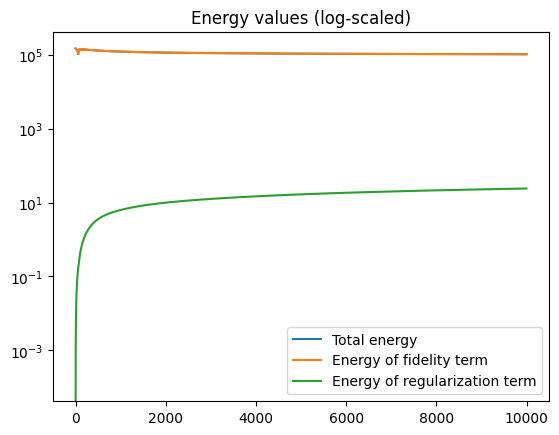

In [8]:
### Convergence of objective function 
E = resu['E']
print(f'Energy value before alignment: {E[0][0]}; Energy value after alignment: {E[-1][0]}')

fig, ax = plt.subplots()
ax.plot(E)
ax.legend(['Total energy','Energy of fidelity term','Energy of regularization term'])
ax.set_yscale('log')
ax.set_title('Energy values (log-scaled)')
plt.show()

## Visualization of Alignment Components

We first compute and display the **matching probabilities** $P_M$ to assess the correspondence between source and target spots.  
Next, we visualise the **matching probability matrix**, which provides a spatial overview of regions with high or low likelihood of alignment.

Matching probabilities: tensor([0.9972, 0.0028])


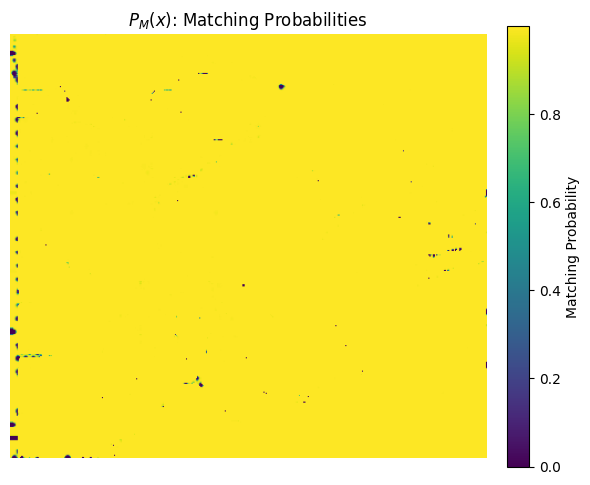

In [9]:
### Matching and Background Probabilities
PM = resu['WM'].cpu()
PB = resu['WB'].cpu()

P = torch.stack((PM,PB))
pi = torch.sum(P,dim=(1,2))
pi += torch.max(pi)*1e-6
pi /= torch.sum(pi)
print('Matching probabilities:', pi)

fig,ax = plt.subplots(figsize = (6,5))
im = ax.imshow(PM)
ax.set_title(r'$P_M(x)$: Matching Probabilities')
ax.axis('off')
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Matching Probability')  

plt.tight_layout()
plt.show()

Next, we visualise the  **diffeomorphic mapping** $(\phi^v\cdot A)(x)$.  

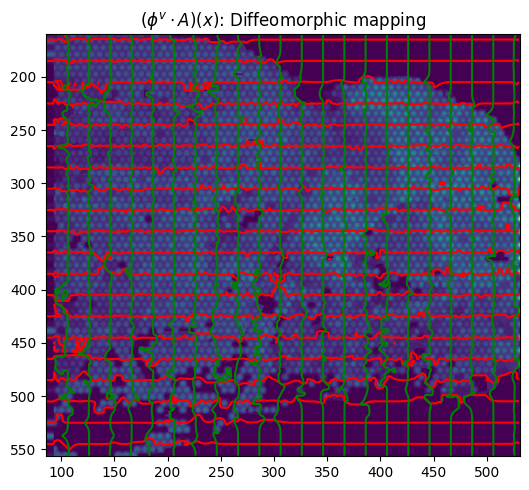

In [10]:
from GALA.utils import build_transform, transform_image_source_to_target
### Phi:  from source to target
xv = resu['xv']
v = resu['v']
A = resu['A']
device = 'cpu'
xI = [YI,XI]
xJ = [YJ,XJ]
xI = [torch.as_tensor(x,device = 'cpu') for x in xI]
xJ = [torch.as_tensor(x,device = 'cpu') for x in xJ]
def extent_from_x(xJ):
    dJ = [x[1]-x[0] for x in xJ]
    extentJ = ( (xJ[1][0] - dJ[1]/2.0).item(),
               (xJ[1][-1] + dJ[1]/2.0).item(),
               (xJ[0][-1] + dJ[0]/2.0).item(),
               (xJ[0][0] - dJ[0]/2.0).item())
    return extentJ

### Forward
phii = build_transform(xv,v,A,torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1))
aI = I[3]
aI = aI[None,...]
phiI = transform_image_source_to_target(xv,v,A,xI,aI,torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1))
extentJ = extent_from_x((YJ,XJ))

### plot
fig,ax = plt.subplots(figsize=(6, 5))
ax.contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels= np.arange( phii.min(), phii.max(), 20)  )
ax.contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels= np.arange( phii.min(), phii.max(), 20))
ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent = extentJ)
ax.set_title(r'$(\phi^v\cdot A)(x)$: Diffeomorphic mapping')
#ax[1].axis('off')

plt.tight_layout()
plt.show()


## Aligned Slices

We next visualise the **aligned source and target slices** to qualitatively assess the performance of GALA.  
This allows us to inspect how well spatial patterns, gene expression distributions, and histological features have been matched after alignment.

In [11]:
def plot_mbsp_gala(spatiali,spatialj,gi,gj,x0,x1,y0,y1,ax,ps1 = 8,ps2 = 15):
    ### Aligned data from GALA
    ax[0].scatter(spatiali[:,0], spatiali[:,1], c= gi,cmap='viridis',
                    s=ps1, alpha=1,marker = 'v',linewidth=0)
    ax[0].scatter(spatialj[:,0], spatialj[:,1], c = gj, cmap='viridis',
                    s=ps1, alpha=1,marker = 'o',linewidth=0)
    ax[0].invert_yaxis()
    ax[0].axis('off')
    ax[0].set_aspect('equal')
    # rectangular
    rect = Rectangle((x0, y0),              
                    x1 - x0,                # Width
                    y1 - y0,                # Height
                    linewidth=2,
                    edgecolor='red',
                    facecolor='none')
    ax[0].add_patch(rect)

    ### Magnified version 
    ax[1].scatter(spatiali[:,0], spatiali[:,1], c= gi,cmap='viridis', 
                    s=ps2, alpha=1,marker = 'v',linewidth=0)
    ax[1].scatter(spatialj[:,0], spatialj[:,1], c = gj,cmap='viridis', 
                    s=ps2, alpha=1,marker = 'o',linewidth=0)
    ax[1].axis('off')
    ax[1].set_aspect('equal')
    ax[1].set_xlim(x0, x1)
    ax[1].set_ylim(y0, y1)
    
    y_top    = max(y0, y1)
    y_bottom = min(y0, y1)
    x_right  = x1
    xlim = ax[1].get_xlim()
    ylim = ax[1].get_ylim()
    width = xlim[1] - xlim[0]
    height = ylim[1] - ylim[0]
    rect_zoom = Rectangle(
        (xlim[0], ylim[0]),  
        width,
        height,
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )
    ax[1].add_patch(rect_zoom)

    con1 = ConnectionPatch(xyA=(x_right, y_bottom), coordsA="data", axesA=ax[0],
                       xyB=(0, 1), coordsB="axes fraction", axesB=ax[1],
                       arrowstyle='-', linestyle='--',linewidth=1, color='0.5')
    con2 = ConnectionPatch(xyA=(x_right, y_top), coordsA="data", axesA=ax[0],
                        xyB=(0, 0), coordsB="axes fraction", axesB=ax[1],
                        arrowstyle='-', linestyle='--',linewidth=1, color='0.5')

    con1.set_clip_on(False)
    con2.set_clip_on(False)
    ax[1].add_artist(con1)
    ax[1].add_artist(con2)

    return(ax)

We visualise the **top three informative genes** in both the aligned source and target slices.  
This highlights how well GALA preserves gene-specific spatial patterns after multimodal alignment.

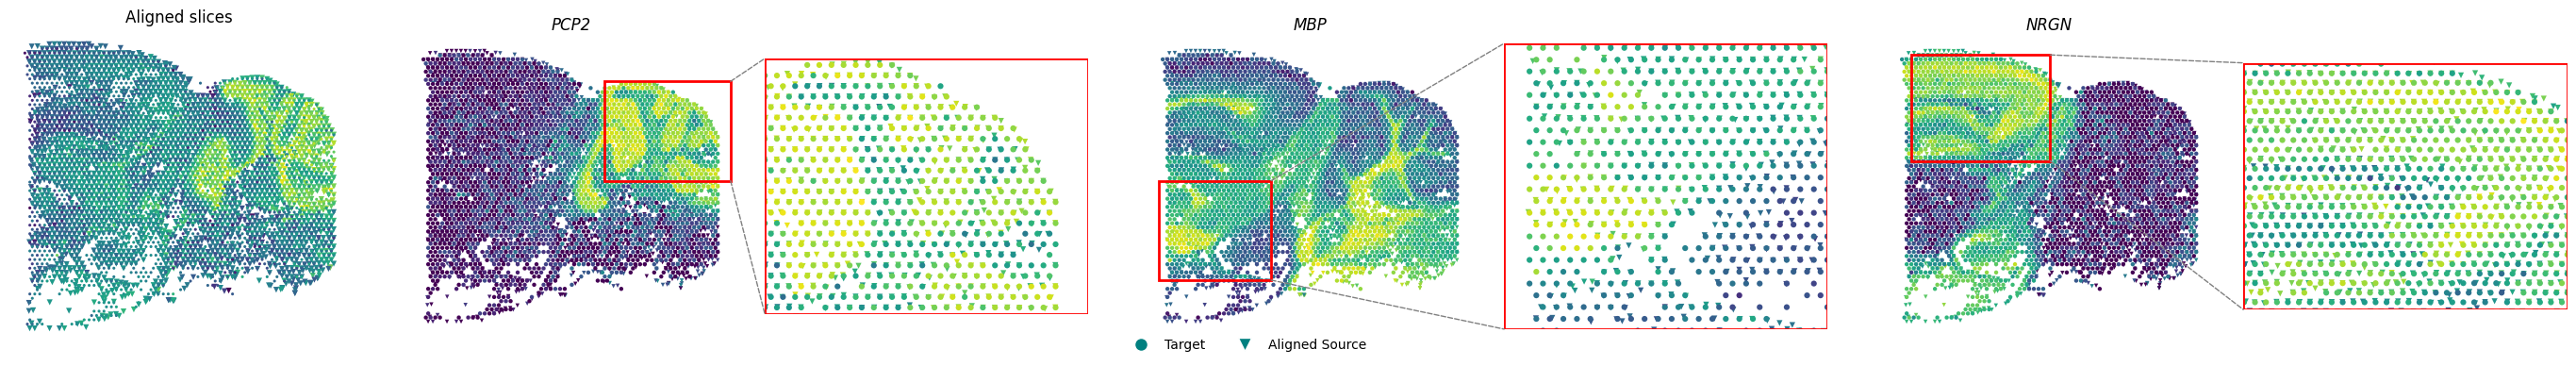

In [12]:
from GALA.utils import alignedada

ps1 = 10
ps2 = 20
markersize = 10
spatial = alignedada(resu,source).obsm['aligned']

fig = plt.figure(figsize=(35,5))  
gs = GridSpec(1, 4, figure=fig, wspace=0.1,width_ratios=[1,2,2,2])
# Aligned stacked slices
gs1 = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0],wspace=0.1)
ax = [fig.add_subplot(gs1[0])][0]
gi = np.array(source.X.sum(axis=1))
gj = np.array(target.X.sum(axis=1))
ax.scatter(spatial[:,0], spatial[:,1], c= gi,cmap='viridis', s= ps2, alpha=1,marker = 'v',linewidth=0)
ax.scatter(spatialj[:,0], spatialj[:,1], c= gj,cmap='viridis', s= ps2, alpha=1,marker = '.',linewidth=0)
ax.set_title('Aligned slices')
ax.axis('off')
ax.set_aspect('equal')
ax.invert_yaxis() 
# PCP2
gi = np.array(source[:,'Pcp2'].X.todense())
gj = np.array(target[:,'Pcp2'].X.todense())
gs2 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1],wspace=0.1)
ax = [fig.add_subplot(gs2[0,i]) for i in range(2)]
plot_mbsp_gala(spatial,spatialj,gi,gj,x0 = 360,x1 = 550,y0 = 350,y1 = 200,ax = ax,ps1 = ps1,ps2 = ps2)
ax[0].set_title('PCP2',fontstyle= 'italic')
# MBP
gi = np.array(source[:,'Mbp'].X.todense())
gj = np.array(target[:,'Mbp'].X.todense())
gs3 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[2],wspace=0.1)
ax = [fig.add_subplot(gs3[0,i]) for i in range(2)]
plot_mbsp_gala(spatial,spatialj,gi,gj,x0 = 80,x1 = 250,y0 = 500,y1 = 350,ax = ax,ps1 = ps1,ps2 = ps2)
ax[0].set_title('MBP',fontstyle= 'italic')
# NRGN
gi = np.array(source[:,'Nrgn'].X.todense())
gj = np.array(target[:,'Nrgn'].X.todense())
gs4 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[3],wspace=0.1)
ax = [fig.add_subplot(gs4[0,i]) for i in range(2)]
ax = plot_mbsp_gala(spatial,spatialj,gi,gj,x0 = 100,x1 = 310,y0 = 320,y1 = 160,ax = ax,ps1 = ps1,ps2 = ps2)
ax[0].set_title('NRGN',fontstyle= 'italic')
# legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Target',
           markerfacecolor='teal', markersize=markersize),
    Line2D([0], [0], marker='v', color='w', label='Aligned Source',
           markerfacecolor='teal', markersize=markersize)
]

fig.legend(handles=legend_elements, 
           loc='lower center', 
           frameon=False,
           ncol = 3,
           bbox_to_anchor=(0.5, 0.12))


#plt.tight_layout()
plt.show()
